In [3]:
import random as random
import Bio
import numpy as np
import sys
import os
import networkx as nx
import random as random
from tqdm import tqdm # loading bar
from utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, fill_graph,new_sp_approxi_combi
from utils_copy import convert_to_desired_format_nr_version, compute_cost, my_traversal_simply, extend_alignment_chaos, find_min_span_edges_testing, parse_fasta_multiple_remove_n
import timeit
from utils_copy import al_integrity_testt
from old_for_testing.sp_approx import sp_approx
from old_for_testing.utils import *
from utils_copy import sum_of_column
from functions_multiple_version import *
import matplotlib.pyplot as plt
import pandas as pd

score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=5


Here comes the distance matrix produced by the alignments: 

[[ 0. 25. 17.]
 [25.  0. 19.]
 [17. 19.  0.]]
this is E (sorted matrix without any stars yet): 
[['' '17' '0' '2']
 ['' '19' '1' '2']
 ['' '25' '0' '1']]
the names of nodes going into the first name dict are: ['0' '1' '2'] and the name_dict is orginally {'0': 0, '1': 1, '2': 2}

 
 this is it 1 of the find_min_span_edges_testing-func.
after that iteration, we end up with this dict: {'0': 0, '1': 1, '2': 0}and the set is: {0, 1} and the len of that set is 2

 
 this is it 2 of the find_min_span_edges_testing-func.
after that iteration, we end up with this dict: {'0': 0, '1': 0, '2': 0}and the set is: {0} and the len of that set is 1
Here are the edges included in the MST, marked with a star! 

[['*' '17' '0' '2']
 ['*' '19' '1' '2']
 ['' '25' '0' '1']]
Here comes the pseudomatrix, filled out with with the edges inclued in the MST: 

[['*' '17' '0' '2']
 ['*' '19' '1' '2']
 ['' '25' '0' '1']]
Starting key for traversal based on

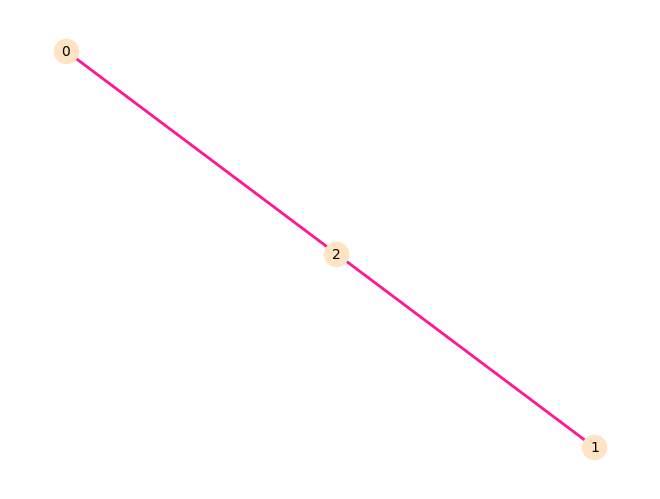

Neighbors of node 0: ['2']
Neighbors of node 1: ['2']
Neighbors of node 2: ['0', '1']
{'2': '0', '1': '2'}
Here come your alignment pairs and the idex dict: 

{'2': '0', '1': '2'}
{'0': '0', '2': '1', '1': '2'}
this is the key: 2 and this is the value: 0

 now aligning....tcaggta and aaagt
Alignments: 
-aaagt-
tcaggta
A right now is: [['-', 't'], ['a', 'c'], ['a', 'a'], ['a', 'g'], ['g', 'g'], ['t', 't'], ['-', 'a']]
M right now: [['a'], ['a'], ['a'], ['g'], ['t']]
i:0, j:0
parent string nr: 0
which is in col:0
I compare a and -
I go to case 3 (char, gap)
Now MA is this: 
 [['-', 't']]
i:0, j:1
parent string nr: 0
which is in col:0
I compare a and a
I go to case 4 (char, char)
Now MA is this: 
 [['-', 't'], ['a', 'c']]
i:1, j:2
parent string nr: 0
which is in col:0
I compare a and a
I go to case 4 (char, char)
Now MA is this: 
 [['-', 't'], ['a', 'c'], ['a', 'a']]
i:2, j:3
parent string nr: 0
which is in col:0
I compare a and a
I go to case 4 (char, char)
Now MA is this: 
 [['-', 't'],

(56,
 [['-', 't', 'c'],
  ['a', 'c', 't'],
  ['a', 'a', '-'],
  ['a', 'g', '-'],
  ['g', 'g', 'c'],
  ['t', 't', 't']],
 array([['', '25', '0', '1'],
        ['', '17', '0', '2'],
        ['', '19', '1', '2']], dtype='<U21'),
 <networkx.classes.graph.Graph at 0x7f5941fb9ba0>)

In [5]:
new_sp_approxi_combi(['aaagt','ctcta','tcaggta'],score_matrix,gap_cost,True)

In [14]:
def new_assembly_OBO(seqs,score_matrix,gapcost):
    # Make a matrix to hold pairwise alignment costs for all alignment combinations!
    matrix = np.full((len(seqs), len(seqs)), np.nan)
    # Loop over all pairs
    for i, seq1 in enumerate(seqs):
        for j, seq2 in enumerate(seqs):
            matrix[i, j] = get_cost_2(linear_C(gap_cost, score_matrix, seq1, seq2))
        print("Here comes the distance matrix produced by the alignments: \n")
        print(matrix)
    matrix_for_MST=matrix #copy the matrix, so that we can keep the old matrix and make a changed version to the "pseudomatrix" version
    matrix_for_MST=convert_to_desired_format_nr_version(matrix_for_MST) #making the "pseudomatrix"
    print("matrix for MST: "+str(matrix_for_MST))
    min_span_edges_res=find_min_span_edges_testing(matrix_for_MST)
    print("min span edges: "+str(min_span_edges_res))
    in_which_MSA_is_it={}
    names= np.unique(min_span_edges_res[:, 2:])
    in_which_MSA_is_it ={name: [int(name),0] for name in names}
    MSA_list=[[[char] for char in seq] for seq in seqs]
    who_aligned_to_who=[]
    k=0
    for row in min_span_edges_res:
        k+=1
        if row[0]=="*":
            node1=row[2]
            node2=row[3]
            print("\n \n \n these are the nodes for the iteration "+ str(k))
            print(node1,node2)
            print("which correspond to these strings I align: "+ str(seqs[int(node1)])+" , "+str(seqs[int(node2)]) )
            who_aligned_to_who.append([node1,node2])

    traversal_order = []
    already_there_set = set()
    queue = []

    # Add the first element to the queue
    queue.append(who_aligned_to_who[0])

    while queue:
        element = queue.pop(0)  # Dequeue the first element from the queue
        node1, node2 = element

        if node1 in already_there_set:
            # Swap nodes if node1 is already in already_there_set
            node1, node2 = node2, node1

        if node1 not in already_there_set or node2 not in already_there_set:
            traversal_order.append([node1, node2])
            already_there_set.add(node1)
            already_there_set.add(node2)

            # Find edges connected to the last added node and enqueue them
            for edge in who_aligned_to_who:
                if edge != element and (edge[0] == node1 or edge[1] == node1 or edge[0] == node2 or edge[1] == node2):
                    queue.append(edge)

    print(traversal_order)

    for element in traversal_order:
            node1=element[0]
            node2=element[1]
            cost=linear_C(gap_cost,score_matrix,seqs[int(node1)],seqs[int(node2)])
            alignment1_str,alignment2_str=linear_backtrack(seqs[int(node1)], seqs[int(node2)], cost, score_matrix, gap_cost)
            alignment1, alignment2 = [*alignment1_str], [*alignment2_str]
            A = [list(e) for e in zip(alignment1,alignment2)]
            print("original alignment, which is gonna be the guide"+str(A))
            united_MSA_new=alt_alt_merge_united(A,MSA_list,in_which_MSA_is_it,node1,node2)
            print("here we have the union: "+str(united_MSA_new))
            which_spot_in_MSA_list_to_update=min(in_which_MSA_is_it[node1][0],in_which_MSA_is_it[node2][0])
            which_spot_in_MSA_list_to_remove=max(in_which_MSA_is_it[node1][0],in_which_MSA_is_it[node2][0])
            MSA_list[which_spot_in_MSA_list_to_update]=united_MSA_new
            MSA_list.pop(which_spot_in_MSA_list_to_remove)
            companions_to_update=[]
            if in_which_MSA_is_it[node1][0]<in_which_MSA_is_it[node2][0]:
                print(str(in_which_MSA_is_it[node1][0])+"is smaller than+"+str( in_which_MSA_is_it[node2][0]) +"so here I went to the original updating stategy")
                how_many_cols_already_in_MS1=find_highest_second_element(in_which_MSA_is_it,which_spot_in_MSA_list_to_update)
                for key, value in in_which_MSA_is_it.items():
                    if value[0]==which_spot_in_MSA_list_to_remove:
                        companions_to_update.append(key)
                    if value[0]>which_spot_in_MSA_list_to_remove:
                        value[0]=(value[0]-1)
                for companion in companions_to_update:
                    print(in_which_MSA_is_it[companion])
                    in_which_MSA_is_it[companion][0]=which_spot_in_MSA_list_to_update
                    col_of_element_in_old_MSA2=in_which_MSA_is_it[companion][1]
                    in_which_MSA_is_it[companion][1]=(how_many_cols_already_in_MS1+col_of_element_in_old_MSA2+1)
            else:
                print(str(in_which_MSA_is_it[node1][0])+"is bigger than+"+str( in_which_MSA_is_it[node2][0]) +"so here I went to the new updating stategy")
                companions_to_update1=[]
                companions_to_update2=[]
                how_many_cols_already_in_MS2=find_highest_second_element(in_which_MSA_is_it,which_spot_in_MSA_list_to_remove) #get the highest nr in MSA2. need to only update dict[0] for MSA1 and only dict[1] for MSA2
                for key, value in in_which_MSA_is_it.items():
                    #how_many_cols_already_in_MS2=find_highest_second_element(in_which_MSA_is_it,which_spot_in_MSA_list_to_remove) #get the highest nr in MSA2. need to only update dict[0] for MSA1 and only dict[1] for MSA2
                    if value[0]==which_spot_in_MSA_list_to_update: #these need their value[1] updated, because they were "pushed downwards" in their alignment
                        companions_to_update1.append(key)
                    if value[0]==which_spot_in_MSA_list_to_remove: #these need their value[0] updated, because they were moved to a new alignment.
                        companions_to_update2.append(key)
                    if value[0]>which_spot_in_MSA_list_to_remove: #these need -1 in their value[1]
                        value[0]=(value[0]-1)
                for companion1 in companions_to_update1:
                    in_which_MSA_is_it[companion1][1]=int(in_which_MSA_is_it[companion1][1])+int(how_many_cols_already_in_MS2)+1
                for companion2 in companions_to_update2:
                    in_which_MSA_is_it[companion2][0]=which_spot_in_MSA_list_to_update
            print("this is the updated dict after it "+str(k)+": "+str(in_which_MSA_is_it))
    print(MSA_list)
    total_cost = compute_cost(MSA_list[0], score_matrix, gap_cost)
    print(total_cost)
     #integrity check part 1, to check if each string is the same before and after, except for gaps.
    for i,seq in enumerate(seqs):
        col_to_extract=in_which_MSA_is_it[str(i)][1]
        j=0
        new_str_with_gaps=[]
        new_str_no_gaps=[]
        while j<=len(MSA_list[0])-1:
            found=MSA_list[0][j][col_to_extract]
            j+=1
            new_str_with_gaps.append(found)
            if found !='-':
                new_str_no_gaps.append(found)
        new_str_no_gaps=''.join(new_str_no_gaps)
        new_str_with_gaps=''.join(new_str_with_gaps)
        if new_str_no_gaps==seq:
            print("integrity check 1 passed for seq "+str(i))
        else:
            print("Yikes, integrity check 1 did not pas for seq "+str(i)+". constrast( new, orig): \n"+str(new_str_no_gaps)+"\n"+str(seq))
     #part 2 lol, are the alignments preserved, expect for gaps???
    print("structure of who_aligned_to_who: ")
    print(who_aligned_to_who)
    for element in who_aligned_to_who:
        seq1_nr=element[0]
        seq2_nr=element[1]
        print("seq1_nr and seq2_nr are: "+str(seq1_nr)+" , "+str(seq2_nr))
        pos_in_MSA_seq1=in_which_MSA_is_it[seq1_nr][1]
        pos_in_MSA_seq2=in_which_MSA_is_it[seq2_nr][1]
        print("pos_in_MSA_seq1,pos_in_MSA_seq2: "+str(pos_in_MSA_seq1)+" , "+str(pos_in_MSA_seq2))
        seq1_from_MSA=[]
        seq2_from_MSA=[]
        j=0
        while j<=len(MSA_list[0])-1:
            found=MSA_list[0][j][pos_in_MSA_seq1]
            seq1_from_MSA.append(found)
            j+=1
        j=0
        while j<=len(MSA_list[0])-1:
            found=MSA_list[0][j][pos_in_MSA_seq2]
            seq2_from_MSA.append(found)
            j+=1
        union=[]
        k=0
        len_max=max(len(seq1_from_MSA),len(seq1_from_MSA))
        while k<=(len_max-1):
            el1=seq1_from_MSA[k]
            el2=seq2_from_MSA[k]
            tuple_like_zip=[el1,el2]
            union.append(tuple_like_zip)
            k+=1
        print("union of the two after merge looks like: "+str(union))
        cost_after_MSA=compute_cost(union,score_matrix,gap_cost)
        if cost_after_MSA==matrix[int(seq1_nr)][int(seq2_nr)]:
            print("integrity test 2 passed for: "+str(seq1_nr)+" and "+ str(seq2_nr))
        else:
            print("Yikes, integrity check 2 did not pas for: "+str(seq1_nr)+" and "+ str(seq2_nr))
            print("Costs were before and after:"+str(matrix[int(node1)][int(node2)])+" and "+str(cost_after_MSA))
            cost_for_suppesed_to_have_been=linear_C(gap_cost,score_matrix,seqs[int(seq1_nr)],seqs[int(seq2_nr)])
            alignment1_str,alignment2_str=linear_backtrack(seqs[int(seq1_nr)], seqs[int(seq2_nr)],cost_for_suppesed_to_have_been, score_matrix, gap_cost)
            alignment1, alignment2 = [*alignment1_str], [*alignment2_str]
            should_have_been= [list(e) for e in zip(alignment1,alignment2)]
            print("should have been:"+ str(should_have_been))
            all_gaps_cols_removed_from_union=[sublist for sublist in union if not all(item == '-' for item in sublist)]
            print(all_gaps_cols_removed_from_union)
            h=0
            while h<=len(should_have_been)-1:
                if should_have_been[h]==all_gaps_cols_removed_from_union[h]:
                    h+=1
                else:
                    print("index of first error: " + str(h) + " out of approximately " + str(len(should_have_been)) + ". The cols are these (should have been, are): " + str(should_have_been[h]) + " and " + str(all_gaps_cols_removed_from_union[h]))
                    sys.exit()
                    h+=1



    total_cost = compute_cost(MSA_list[0], score_matrix, gap_cost)
    print(total_cost)





    return(matrix,min_span_edges_res,in_which_MSA_is_it,MSA_list, total_cost)


new_assembly_OBO(['aaagt','ctcta','tcaggta','gtgtaattg','tat','gag','cat'],score_matrix,gap_cost)


Here comes the distance matrix produced by the alignments: 

[[ 0. 25. 17. 26. 15. 12. 15.]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]]
Here comes the distance matrix produced by the alignments: 

[[ 0. 25. 17. 26. 15. 12. 15.]
 [25.  0. 19. 26. 15. 22. 15.]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]]
Here comes the distance matrix produced by the alignments: 

[[ 0. 25. 17. 26. 15. 12. 15.]
 [25.  0. 19. 26. 15. 22. 15.]
 [17. 19.  0. 21. 20. 24. 20.]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]]
Here comes the distance matrix produced by the alignments: 

[[ 0. 25. 17. 26. 15. 12. 15.]
 [25.  0. 19. 26. 15. 22. 15.]
 [17. 19.  0. 21. 20. 24. 20.]
 [26. 26.

(array([[ 0., 25., 17., 26., 15., 12., 15.],
        [25.,  0., 19., 26., 15., 22., 15.],
        [17., 19.,  0., 21., 20., 24., 20.],
        [26., 26., 21.,  0., 30., 30., 32.],
        [15., 15., 20., 30.,  0., 10.,  2.],
        [12., 22., 24., 30., 10.,  0., 10.],
        [15., 15., 20., 32.,  2., 10.,  0.]]),
 array([['*', '2', '4', '6'],
        ['*', '10', '4', '5'],
        ['', '10', '5', '6'],
        ['*', '12', '0', '5'],
        ['', '15', '0', '4'],
        ['', '15', '0', '6'],
        ['*', '15', '1', '4'],
        ['', '15', '1', '6'],
        ['*', '17', '0', '2'],
        ['', '19', '1', '2'],
        ['', '20', '2', '4'],
        ['', '20', '2', '6'],
        ['*', '21', '2', '3'],
        ['', '22', '1', '5'],
        ['', '24', '2', '5'],
        ['', '25', '0', '1'],
        ['', '26', '0', '3'],
        ['', '26', '1', '3'],
        ['', '30', '3', '4'],
        ['', '30', '3', '5'],
        ['', '32', '3', '6']], dtype='<U21'),
 {'0': [0, 2],
  '1': [0, 3],
  